https://www.kaggle.com/kmader/nuclei-overview-to-submission/notebook  
https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277/notebook

In [1]:
import os
import glob
import warnings
import numpy as np
import pandas as pd
from glob import glob

import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread, imshow

%matplotlib inline
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

In [2]:
all_path = glob(os.path.join('data', '*_stage1', '*', '*', '*'))

len(all_path)

30196

In [3]:
path_df = pd.DataFrame(index=all_path)

img_type = lambda path: path.split('/')[-2]
img_id = lambda path: path.split('/')[-3]
img_group = lambda path: path.split('/')[-4].split('_')[0]
img_stage =lambda path: path.split('/')[-4].split('_')[1]

path_df['Image_STAGE'] = path_df.index.map(img_stage)
path_df['Image_GROUP'] = path_df.index.map(img_group)
path_df['Image_ID'] = path_df.index.map(img_id)
path_df['Image_TYPE'] = path_df.index.map(img_type)


In [4]:
path_df.head()

,Image_ID,Image_GROUP,Image_TYPE,Image_STAGE
data/train_stage1/a9d884ba0929dac87c2052ce5b15034163685317d7cff45c40b0f7bd9bd4d9e7/masks/235e0f8b86d5c55c4a06824609a73529f635c35662e923125afa6547bb3e94fc.png,a9d884ba0929dac87c2052ce5b15034163685317d7cff4...,train,masks,stage1
data/train_stage1/a9d884ba0929dac87c2052ce5b15034163685317d7cff45c40b0f7bd9bd4d9e7/masks/f7bcd4e0827008b727de64a8cb8b711c05a60d70ea5ec502750889a4c16ff649.png,a9d884ba0929dac87c2052ce5b15034163685317d7cff4...,train,masks,stage1
data/train_stage1/a9d884ba0929dac87c2052ce5b15034163685317d7cff45c40b0f7bd9bd4d9e7/masks/11ac8eace5d73fc8054822b46db13e09813527faa13ced27b34438a71ae283fe.png,a9d884ba0929dac87c2052ce5b15034163685317d7cff4...,train,masks,stage1
data/train_stage1/a9d884ba0929dac87c2052ce5b15034163685317d7cff45c40b0f7bd9bd4d9e7/masks/284555ce90e1a496fa3614caebd5c950e8958bcb6fcba15a3c3348adf6f95a45.png,a9d884ba0929dac87c2052ce5b15034163685317d7cff4...,train,masks,stage1
data/train_stage1/a9d884ba0929dac87c2052ce5b15034163685317d7cff45c40b0f7bd9bd4d9e7/masks/f3aa2fb4bbf59cadb44b80816e27829d53a42a3070b25344b940d74c7f904081.png,a9d884ba0929dac87c2052ce5b15034163685317d7cff4...,train,masks,stage1


In [5]:
path_df.describe()

,Image_ID,Image_GROUP,Image_TYPE,Image_STAGE
count,30196,30196,30196,30196
unique,735,2,2,1
top,a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a98...,train,masks,stage1
freq,376,30131,29461,30196


### Train

In [6]:
%%time

train_df = path_df.query('Image_GROUP=="train"')
train_rows = []
group_cols = ['Image_STAGE', 'Image_ID']

for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks_path'] = n_rows.query('Image_TYPE == "masks"').index.tolist()
    c_row['image_path'] = n_rows.query('Image_TYPE == "images"').index[0]
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)

CPU times: user 2.23 s, sys: 36 ms, total: 2.27 s
Wall time: 2.25 s


In [7]:
# %%time

train_img_df['shape'] = train_img_df['image_path'].map(lambda x: imread(x).shape)
train_img_df['shape'].value_counts()

# train_img_df['max'] = train_img_df['image_path'].map(lambda x: imread(x).max())
# train_img_df['max'].value_counts()

# train_img_df['min'] = train_img_df['image_path'].map(lambda x: imread(x).min())
# train_img_df['min'].value_counts()

(256, 256, 4)      334
(256, 320, 4)      112
(520, 696, 4)       92
(360, 360, 4)       91
(1024, 1024, 4)     16
(512, 640, 4)       13
(603, 1272, 4)       6
(260, 347, 4)        5
(1040, 1388, 4)      1
Name: shape, dtype: int64

In [8]:
img_height, img_width, img_channels = 256, 256, 3

Train Images

In [9]:
%%time
image_array_list = [resize(imread(train_img_df.loc[_, 'image_path']), (img_height, img_width), preserve_range=True) \
                    for _ in range(train_img_df.shape[0])]

CPU times: user 13.7 s, sys: 22.6 s, total: 36.2 s
Wall time: 11.2 s


In [10]:
image_array = np.stack(image_array_list)[:, :, :, :3]

In [13]:
image_array.shape

(670, 256, 256, 3)

Train Masks

In [14]:
%%time
masks_array_list = [resize(np.sum(np.stack([imread(mask_path) for mask_path in train_img_df.loc[_, 'masks_path']]), axis=0), #np.max
                           (img_height, img_width), preserve_range=True) for _ in range(train_img_df.shape[0])]

CPU times: user 34.4 s, sys: 35.4 s, total: 1min 9s
Wall time: 31.9 s


In [15]:
masks_array = (np.stack(masks_array_list) / 255).astype(int)

In [16]:
masks_array.shape

(670, 256, 256)

Save

In [ ]:
save_path = 'stage1_train_data_compressed.npz'

In [17]:
np.savez_compressed(save_path, images=image_array, masks=masks_array)

Load

In [19]:
load_path = 'stage1_train_data_compressed.npz'

In [20]:
%%time
with np.load(load_path) as f:
    print(f.files)
    train_images = f['images']
    train_masks = f['masks']

['masks', 'images']
CPU times: user 3.9 s, sys: 3.11 s, total: 7 s
Wall time: 7 s


/home/liushrui/install/anaconda3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


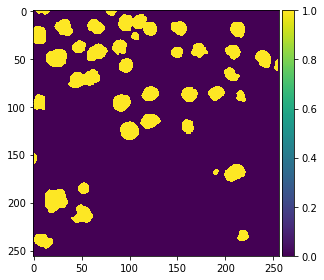

In [21]:
imshow(train_masks[100,:,:])

In [22]:
train_img_df.loc[100, :]

Image_ID       23830d0e51245fc0c9e410efa4c17d2a7d83a0104a3777...
Image_STAGE                                               stage1
image_path     data/train_stage1/23830d0e51245fc0c9e410efa4c1...
masks_path     [data/train_stage1/23830d0e51245fc0c9e410efa4c...
shape                                              (256, 256, 4)
Name: 100, dtype: object

/home/liushrui/install/anaconda3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


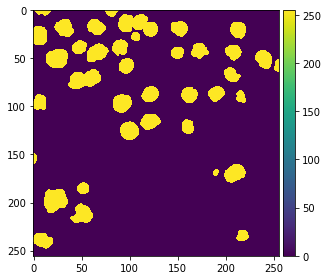

In [23]:
s = np.sum(np.stack([imread(mask_path) for mask_path in train_img_df.loc[100, 'masks_path']]), 0)

imshow(s)

/home/liushrui/install/anaconda3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


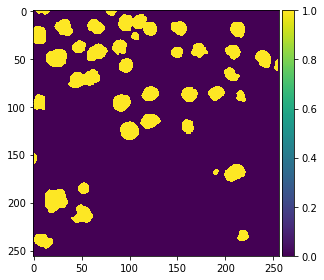

In [24]:
imshow(masks_array[100,:,:])

/home/liushrui/install/anaconda3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


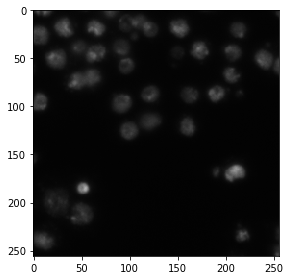

In [25]:
imshow(imread(train_img_df.loc[100, 'image_path']))

### Test

In [29]:
test_df = path_df.query('Image_GROUP=="test"')
test_rows = []
group_cols = ['Image_STAGE', 'Image_ID']

for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['image_path'] = n_rows.query('Image_TYPE == "images"').index[0]
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows)
test_img_df['shape'] = test_img_df['image_path'].map(lambda x:imread(x).shape)

In [31]:
test_img_df.head()

,Image_ID,Image_STAGE,image_path,shape
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,stage1,data/test_stage1/0114f484a16c152baa2d82fdd4374...,"(256, 256, 4)"
1,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,stage1,data/test_stage1/0999dab07b11bc85fb8464fc36c94...,"(519, 253, 3)"
2,0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed3...,stage1,data/test_stage1/0a849e0eb15faa8a6d7329c3dd66a...,"(256, 256, 3)"
3,0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd4...,stage1,data/test_stage1/0e132f71c8b4875c3c2dd7a229974...,"(256, 256, 4)"
4,0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa...,stage1,data/test_stage1/0ed3555a4bd48046d3b63d8baf03a...,"(256, 256, 4)"


In [32]:
test_img_df['shape'].value_counts()

(256, 256, 4)    20
(512, 640, 4)     8
(512, 680, 3)     8
(256, 256, 3)     4
(519, 253, 3)     4
(520, 348, 3)     4
(260, 347, 4)     4
(520, 696, 4)     4
(524, 348, 3)     4
(519, 161, 3)     2
(519, 162, 3)     2
(390, 239, 4)     1
Name: shape, dtype: int64

In [45]:
%%time
test_image_array_list = [resize(imread(test_img_df.loc[_, 'image_path']), (img_height, img_width), preserve_range=True)[:,:,:3] \
                         for _ in range(test_img_df.shape[0])]

CPU times: user 1.39 s, sys: 1.94 s, total: 3.32 s
Wall time: 1.11 s


In [46]:
test_image_array = np.stack(test_image_array_list)
test_image_array.shape

(65, 256, 256, 3)

In [50]:
test_save_path = 'stage1_test_data_compressed.npz'

In [59]:
test_image_shape = test_img_df['shape'].values

In [64]:
np.savez_compressed(test_save_path, images=test_image_array, shapes=test_image_shape)

In [65]:
test_img_df

,Image_ID,Image_STAGE,image_path,shape
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,stage1,data/test_stage1/0114f484a16c152baa2d82fdd4374...,"(256, 256, 4)"
1,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,stage1,data/test_stage1/0999dab07b11bc85fb8464fc36c94...,"(519, 253, 3)"
2,0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed3...,stage1,data/test_stage1/0a849e0eb15faa8a6d7329c3dd66a...,"(256, 256, 3)"
3,0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd4...,stage1,data/test_stage1/0e132f71c8b4875c3c2dd7a229974...,"(256, 256, 4)"
4,0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa...,stage1,data/test_stage1/0ed3555a4bd48046d3b63d8baf03a...,"(256, 256, 4)"
5,0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c0...,stage1,data/test_stage1/0f1f896d9ae5a04752d3239c69040...,"(512, 680, 3)"
6,1747f62148a919c8feb6d607faeebdf504b5e2ad42b6b1...,stage1,data/test_stage1/1747f62148a919c8feb6d607faeeb...,"(512, 640, 4)"
7,17b9bf4356db24967c4677b8376ac38f826de73a88b93a...,stage1,data/test_stage1/17b9bf4356db24967c4677b8376ac...,"(512, 680, 3)"
8,1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c...,stage1,data/test_stage1/1879f4f4f05e2bada0ffeb46c128b...,"(512, 640, 4)"
9,191b2b2205f2f5cc9da04702c5d422bc249faf8bca1107...,stage1,data/test_stage1/191b2b2205f2f5cc9da04702c5d42...,"(256, 256, 4)"
